In [6]:
import pandas as pd
import numpy as np
import umap.umap_ as umap
from plotly import graph_objects as go
from sklearn.cluster import KMeans
import shutil
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [10]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics

In [11]:
import plotly.io as pio
pio.renderers.default = 'notebook'

## 先對DATA進行簡單了解及清理

In [8]:
#Loading the dataset
df = pd.read_csv("marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(df))
df.head()

Number of datapoints: 2240


ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

客戶基本資訊:'ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'Complain'  
客戶消費情況:'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'  
客戶購物習慣:'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth'  
客戶是否接受推播:'NumDealsPurchases','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response'  
其他:'Z_CostContact', 'Z_Revenue'  
  
1.Income有缺失值  
2.Dt_Customer儲存形式非日期,可能需要轉換  
3.有類別變數需要進行轉換

In [9]:
#Dt_Customer進行轉換及簡單查看
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
dates = []
for i in df["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("最新的客戶:",max(dates))
print("最老的客戶:",min(dates))

最新的客戶: 2014-12-06
最老的客戶: 2012-01-08


In [10]:
#新增特徵"Customer_For"(註冊長度)
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
df["Customer_For"] = days
df["Customer_For"] = pd.to_numeric(df["Customer_For"], errors="coerce")

In [11]:
print("Total categories in the feature Marital_Status:\n", df["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", df["Education"].value_counts())

Total categories in the feature Marital_Status:
 Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64 

Total categories in the feature Education:
 Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64


In [12]:
print("Total categories in the feature Z_CostContact:\n", df["Z_CostContact"].value_counts(), "\n")
print("Total categories in the feature Z_Revenue:\n", df["Z_Revenue"].value_counts())

Total categories in the feature Z_CostContact:
 3    2240
Name: Z_CostContact, dtype: int64 

Total categories in the feature Z_Revenue:
 11    2240
Name: Z_Revenue, dtype: int64


新增數項新特徵:
從"Year_Birth"中萃取"Age"  
加總所有消費為"Spent"  
"Living_With",將"Marital_Status"進行簡化為兩類"Partner"及"Alone"  
"Children",將"Kidhome"及"Teenhome"加總  
"Family_Size", 將家庭人數進行加總  
"Is_Parent", 判別是否為父母  
"Education"進行類別縮減

In [13]:
#Feature Engineering
#Age of customer today 
df["Age"] = 2021-df["Year_Birth"]

#Total spendings on various items
df["Spent"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]

#Deriving living situation by marital status"Alone"
df["Living_With"]=df["Marital_Status"].replace({"Married":"Relationship", "Together":"Relationship", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
df["Children"]=df["Kidhome"]+df["Teenhome"]

#Feature for total members in the householde
df["Family_Size"] = df["Living_With"].replace({"Alone": 1, "Relationship":2})+ df["Children"]

#Feature pertaining parenthood
df["Is_Parent"] = np.where(df.Children> 0, 1, 0)

#Segmenting education levels in three groups
df["Education"]=df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Postgraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
df=df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth"]
df = df.drop(to_drop, axis=1)

In [14]:
#先對categorical features進行Label encoding
s = (df.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables in the dataset:", object_cols)

df["Education"]=df["Education"].replace({"Undergraduate":0, "Graduate":1, "Postgraduate":2})
df["Living_With"]=df["Living_With"].replace({"Alone":0, "Relationship":1})

Categorical variables in the dataset: ['Education', 'Living_With']


In [15]:
df.describe()

ID    Education         Income      Kidhome     Teenhome  \
count   2240.000000  2240.000000    2216.000000  2240.000000  2240.000000   
mean    5592.159821     1.448661   52247.251354     0.444196     0.506250   
std     3246.662198     0.543793   25173.076661     0.538398     0.544538   
min        0.000000     0.000000    1730.000000     0.000000     0.000000   
25%     2828.250000     1.000000   35303.000000     0.000000     0.000000   
50%     5458.500000     1.000000   51381.500000     0.000000     0.000000   
75%     8427.750000     2.000000   68522.000000     1.000000     1.000000   
max    11191.000000     2.000000  666666.000000     2.000000     2.000000   

           Recency        Wines       Fruits         Meat         Fish  ...  \
count  2240.000000  2240.000000  2240.000000  2240.000000  2240.000000  ...   
mean     49.109375   303.935714    26.302232   166.950000    37.525446  ...   
std      28.962453   336.597393    39.773434   225.715373    54.628979  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%      24.000000    23.750000     1.000000    16.000000     3.000000  ...   
50%      49.000000   173.500000     8.000000    67.000000    12.000000  ...   
75%      74.000000   504.250000    33.000000   232.000000    50.000000  ...   
max      99.000000  1493.000000   199.000000  1725.000000   259.000000  ...   

       AcceptedCmp2     Complain     Response  Customer_For          Age  \
count   2240.000000  2240.000000  2240.000000  2.240000e+03  2240.000000   
mean       0.013393     0.009375     0.149107  4.424054e+16    52.194196   
std        0.114976     0.096391     0.356274  2.006466e+16    11.984069   
min        0.000000     0.000000     0.000000  0.000000e+00    25.000000   
25%        0.000000     0.000000     0.000000  2.944080e+16    44.000000   
50%        0.000000     0.000000     0.000000  4.432320e+16    51.000000   
75%        0.000000     0.000000     0.000000  5.920560e+16    62.000000   
max        1.000000     1.000000     1.000000  9.184320e+16   128.000000   

             Spent  Living_With     Children  Family_Size    Is_Parent  
count  2240.000000  2240.000000  2240.000000  2240.000000  2240.000000  
mean    605.798214     0.644643     0.950446     2.595089     0.715179  
std     602.249288     0.478728     0.751803     0.906959     0.451430  
min       5.000000     0.000000     0.000000     1.000000     0.000000  
25%      68.750000     0.000000     0.000000     2.000000     0.000000  
50%     396.000000     1.000000     1.000000     3.000000     1.000000  
75%    1045.500000     1.000000     1.000000     3.000000     1.000000  
max    2525.000000     1.000000     3.000000     5.000000     1.000000  

[8 rows x 31 columns]

<AxesSubplot:>

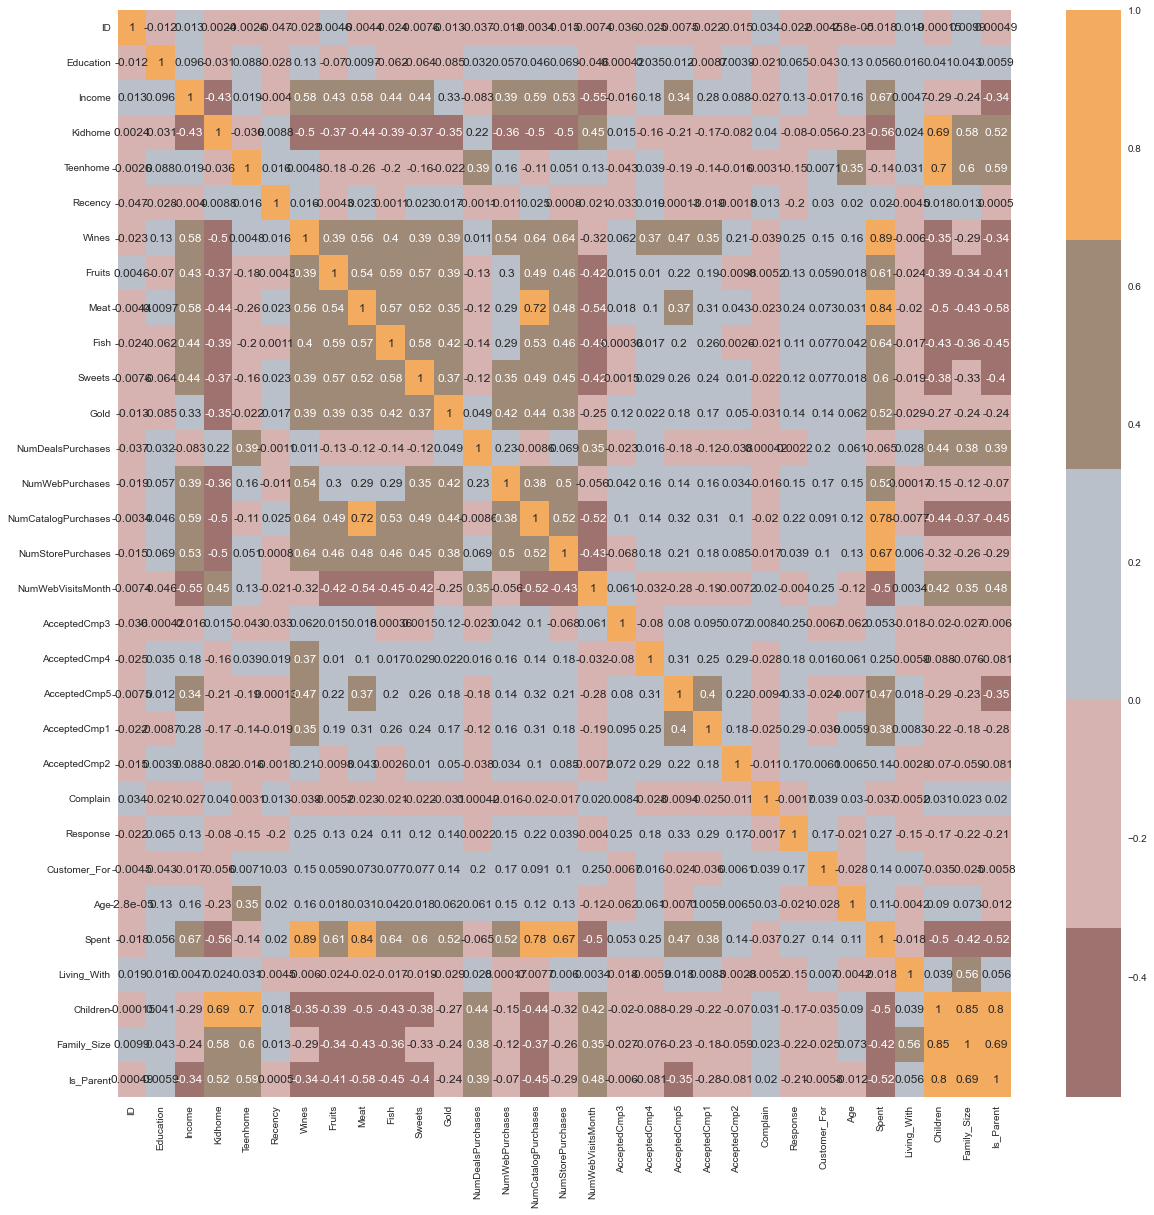

In [16]:
#correlation matrix
corrmat= df.corr()
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

可以看出部分特徵中存在outliers  
如age存在128yr,Income存在666666...  
針對幾項特徵進行觀察

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 576x396 with 0 Axes>

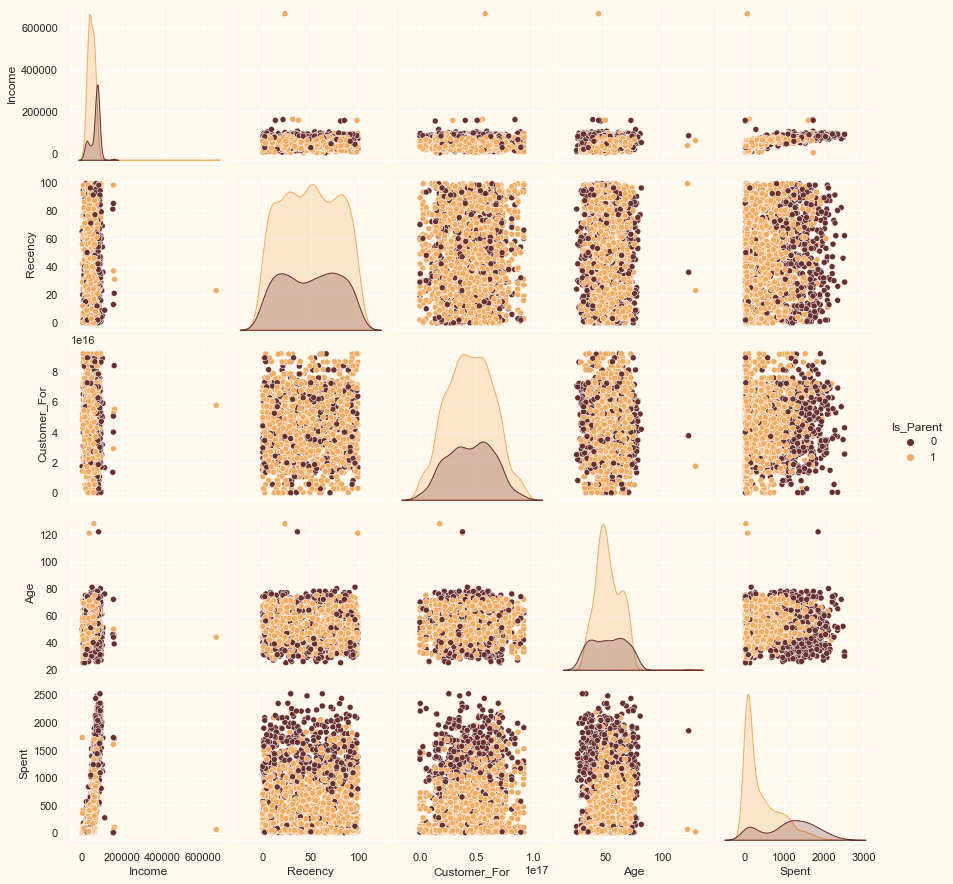

In [17]:
#To plot some selected features 
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(df[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

In [18]:
#Dropping the outliers by setting a cap on Age and income. 
drop_list = list(np.concatenate([df[(df["Age"]>90)].index.values,df[(df["Income"]>600000)].index.values]))
df.drop(drop_list,inplace=True)
print("The total number of data-points after removing the outliers are:", len(df))

The total number of data-points after removing the outliers are: 2236


In [19]:
#Income與spent高度相關,建立兩者的線性模型迴歸進行補植
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm_df = df.dropna()
lm.fit(lm_df['Spent'].values.reshape(-1, 1),lm_df['Income'].values.reshape(-1, 1))

LinearRegression()

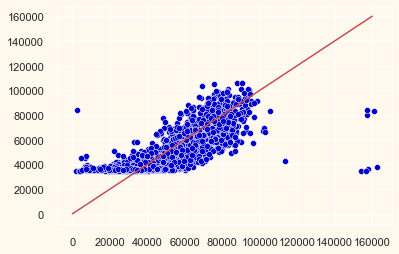

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
p1 = sns.scatterplot(x=lm_df["Income"].values,y=lm.predict(lm_df['Spent'].values.reshape(-1, 1)).reshape(lm_df["Income"].values.shape[0],),color = 'Mediumblue')
p2 = sns.lineplot(x=np.linspace(0, 160000, 160000), y=np.linspace(0, 160000, 160000), color='r', ax=ax)
plt.show()

In [21]:
fill_list = list(df[df["Income"].isna()].index.values)
for rows in fill_list:
    df.loc[rows,"Income"] = lm.predict(np.array(df.loc[rows,"Spent"]).reshape(1, -1))[0][0]

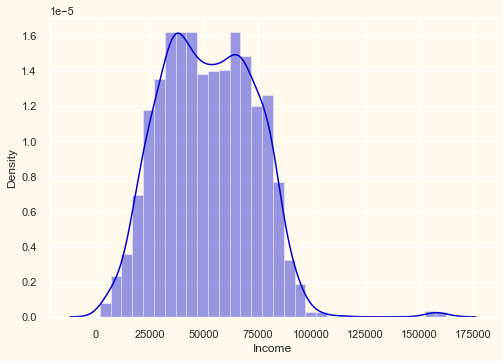

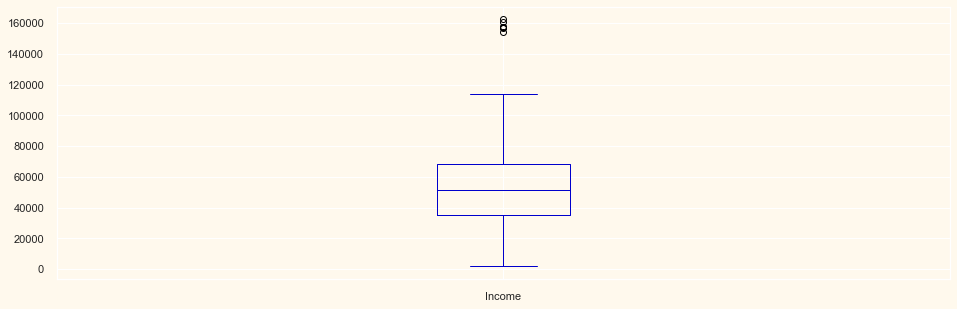

In [22]:
sns.distplot(df["Income"],color = 'Mediumblue')
plt.show()
df["Income"].plot.box(figsize=(16,5),color = 'MediumBlue')
plt.show()

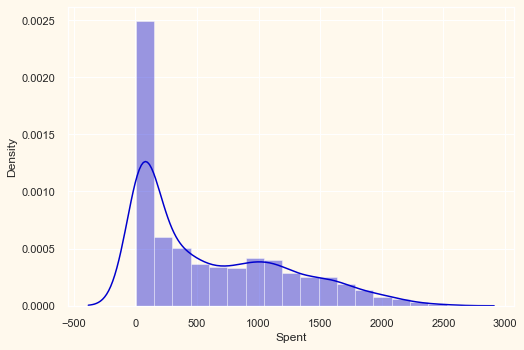

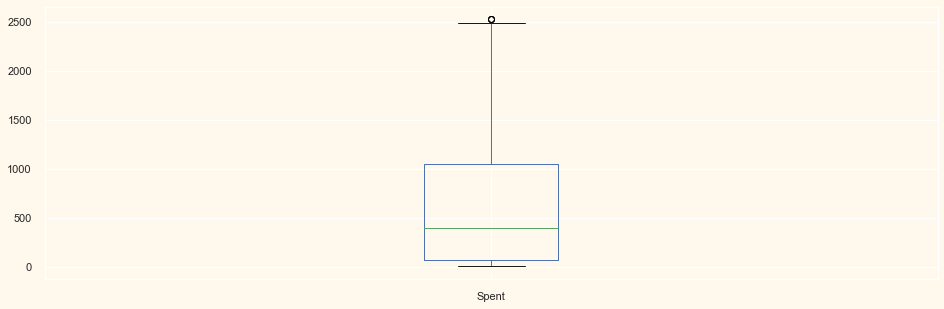

In [23]:
sns.distplot(df["Spent"],color = 'mediumblue')
plt.show()
df["Spent"].plot.box(figsize=(16,5))
plt.show()

## 資料前處理  
已完成feature encoding,尚需  
1.標準化  
2.降維

In [24]:
df.reset_index(drop=True, inplace=True)

In [25]:
#標準化
# creating a subset of dataframe by dropping the features on deals accepted and promotions
non_num_cols = ['ID','Education','Living_With','Is_Parent','AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
#Scaling
scaler = StandardScaler()
scaler.fit(df[[col for col in list(df.columns) if col not in non_num_cols]])
scaled_df = pd.DataFrame(scaler.transform(df[[col for col in list(df.columns) if col not in non_num_cols]]),columns= df[[col for col in list(df.columns) if col not in non_num_cols]].columns )
scaled_df = pd.merge(scaled_df,df[non_num_cols],left_index=True, right_index=True)

In [26]:
#多類別變數PCA前需one-hot encoding
scaled_df = scaled_df.join(pd.get_dummies(scaled_df.Education).rename(columns={0:'Education_Undergraduate',1:'Education_Graduate',2:'Education_Postgraduate'}))
scaled_df.drop(['Education','Education_Undergraduate'],axis=1,inplace=True)

In [128]:
scaled_df

Income   Kidhome  Teenhome   Recency     Wines    Fruits      Meat  \
0     0.289565 -0.824939 -0.930615  0.306856  0.983228  1.554170  1.679746   
1    -0.259890  1.032627  0.905974 -0.383971 -0.871064 -0.636431 -0.713455   
2     0.917334 -0.824939 -0.930615 -0.798467  0.362159  0.572177 -0.177201   
3    -1.177574  1.032627 -0.930615 -0.798467 -0.871064 -0.560893 -0.651409   
4     0.296786  1.032627 -0.930615  1.550344 -0.389661  0.421101 -0.217088   
...        ...       ...       ...       ...       ...       ...       ...   
2231  0.433288 -0.824939  0.905974 -0.107640  1.203128  0.421101  0.066551   
2232  0.563314  2.890194  0.905974  0.237773  0.302727 -0.661610 -0.607091   
2233  0.235663 -0.824939 -0.930615  1.446720  1.794481  0.546997  0.221666   
2234  0.807014 -0.824939  0.905974 -1.420212  0.368102  0.093769  0.208371   
2235  0.044095  1.032627  0.905974 -0.314889 -0.654136 -0.586072 -0.469703   

          Fish    Sweets      Gold  ...  Is_Parent  AcceptedCmp3  \
0     2.461068  1.475396  0.845669  ...          0             0   
1    -0.650414 -0.631638 -0.729742  ...          1             0   
2     1.344595 -0.147262 -0.038098  ...          0             0   
3    -0.503991 -0.583200 -0.748954  ...          1             0   
4     0.154911 -0.001950 -0.556831  ...          1             0   
...        ...       ...       ...  ...        ...           ...   
2231  0.081700  2.201960  3.900428  ...          1             0   
2232 -0.687019 -0.655857 -0.691317  ...          1             0   
2233 -0.101329 -0.365231 -0.383920  ...          0             0   
2234  0.777208  0.070707  0.326936  ...          1             0   
2235 -0.650414 -0.631638 -0.441557  ...          1             0   

      AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0                0             0             0             0         0   
1                0             0             0             0         0   
2                0             0             0             0         0   
3                0             0             0             0         0   
4                0             0             0             0         0   
...            ...           ...           ...           ...       ...   
2231             0             0             0             0         0   
2232             0             0             1             0         0   
2233             1             0             0             0         0   
2234             0             0             0             0         0   
2235             0             0             0             0         0   

      Response  Education_Graduate  Education_Postgraduate  
0            1                   1                       0  
1            0                   1                       0  
2            0                   1                       0  
3            0                   1                       0  
4            0                   0                       1  
...        ...                 ...                     ...  
2231         0                   1                       0  
2232         0                   0                       1  
2233         0                   1                       0  
2234         0                   0                       1  
2235         1                   0                       1  

[2236 rows x 32 columns]

## 進行分群  

In [27]:
scaled_df.drop('ID',axis=1,inplace=True)
#non_cols = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']
#pca_df = scaled_df[[col for col in list(scaled_df.columns) if col not in non_cols]]
pca_df = scaled_df

In [28]:
#PCA
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
reduced_df = pca.fit_transform(pca_df.iloc[:,:].values)

In [29]:
reduced_df

array([[ 4.75513311, -0.05102086,  2.5072679 ],
       [-2.86824796,  0.17892101, -2.27410092],
       [ 2.33699531, -0.72028466, -0.04977021],
       ...,
       [ 2.34760895, -1.64786919,  0.19833866],
       [ 1.71465418,  1.41884529, -1.70349162],
       [-2.58143458,  1.78096286, -0.17441831]])

In [30]:
labels = scaled_df.Response.values
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_df[:,0],
    y=reduced_df[:,1],
    z=reduced_df[:,2],
    mode='markers',
    marker=dict(
        size=3,
        color=scaled_df.Response.values,
        opacity=0.8,
        line=dict(
            color='black',
            width=0
        )
    ),
    text=labels
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

Elbow Method to determine the number of clusters to be formed:


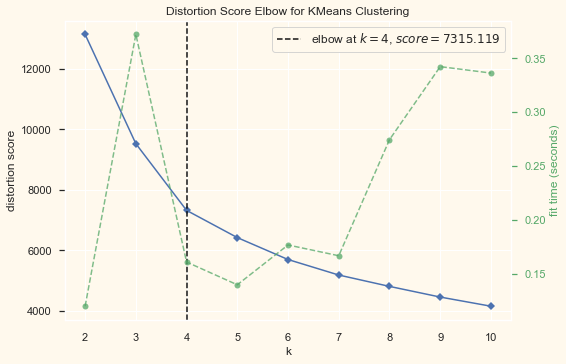

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(reduced_df)
Elbow_M.show()

In [32]:
#UMAP
dimension_reductor = umap.UMAP(n_components=3, n_neighbors=50, random_state=42)
reduced_df_umap = dimension_reductor.fit_transform(scaled_df.iloc[:,:].values)

In [33]:
reduced_df_umap

array([[ 7.315549  ,  1.0861013 ,  4.951771  ],
       [ 0.793089  , 10.472472  ,  0.7485777 ],
       [ 6.396898  ,  1.1300093 ,  5.056348  ],
       ...,
       [ 6.630947  ,  0.43370086,  4.6250687 ],
       [ 7.7541656 ,  6.8945413 ,  1.9358666 ],
       [ 1.662049  , 10.5701065 ,  1.237985  ]], dtype=float32)

In [34]:
labels = scaled_df.Response.values
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_df_umap[:,0],
    y=reduced_df_umap[:,1],
    z=reduced_df_umap[:,2],
    mode='markers',
    marker=dict(
        size=3,
        color=scaled_df.Response.values,
        opacity=0.8,
        line=dict(
            color='black',
            width=0
        )
    ),
    text=labels
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

從UMAP結果中可以看出明顯的分為4群  
利用分群法將這四群分出來

In [35]:
#使用k-means嘗試分類
cls = KMeans(n_clusters=4, init = 'k-means++')
cls_ids = cls.fit_predict(reduced_df_umap)

In [36]:
labels = cls_ids
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_df_umap[:,0],
    y=reduced_df_umap[:,1],
    z=reduced_df_umap[:,2],
    mode='markers',
    marker=dict(
        size=3,
        color=np.array(['red', 'blue', 'green','yellow'])[cls_ids],
        opacity=0.8,
        line=dict(
            color='black',
            width=0
        )
    ),
    text=labels
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [146]:
cluster = pd.Series(cls_ids)
cluster.name = 'clusters'
scaled_df = scaled_df.join(cluster)

In [148]:
#先將分群結果存檔
scaled_df.to_csv('output.csv',index=False)

## 檢查此分群結果下的差別

In [12]:
output = pd.read_csv('output.csv')

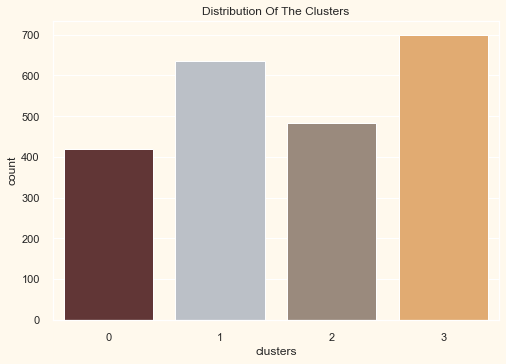

In [42]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=output["clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

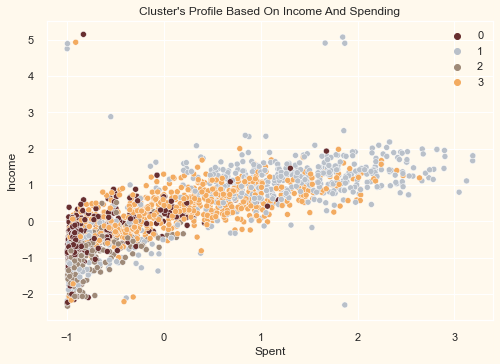

In [44]:
pl = sns.scatterplot(data = output,x=output["Spent"], y=output["Income"],hue=output["clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

從Spent及Income上較難看出四個組別的差異性  
從不同類別產品的消費上來看是否存在差異

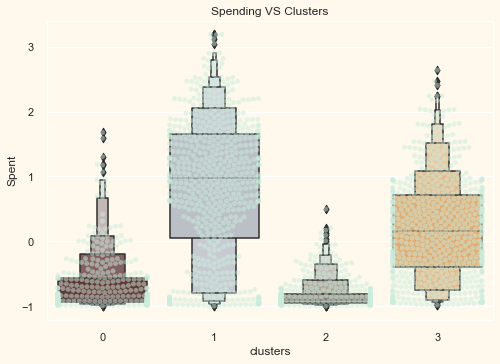

In [48]:
plt.figure()
pl=sns.swarmplot(x=output["clusters"], y=output["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["clusters"], y=output["Spent"], palette=pal)
pl.set_title("Spending VS Clusters")
plt.show()

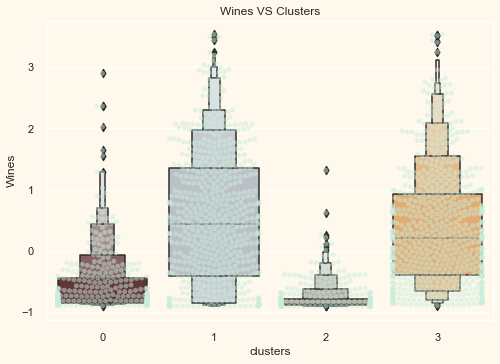

In [50]:
plt.figure()
pl=sns.swarmplot(x=output["clusters"], y=output["Wines"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["clusters"], y=output["Wines"], palette=pal)
pl.set_title("Wines VS Clusters")
plt.show()

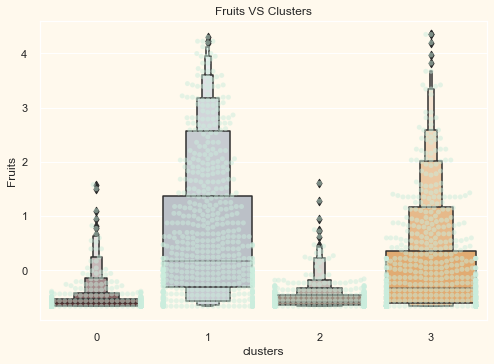

In [51]:
plt.figure()
pl=sns.swarmplot(x=output["clusters"], y=output["Fruits"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["clusters"], y=output["Fruits"], palette=pal)
pl.set_title("Fruits VS Clusters")
plt.show()

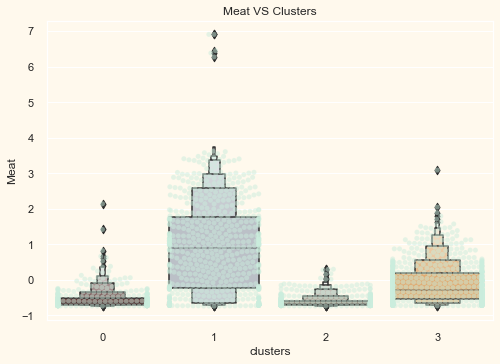

In [52]:
plt.figure()
pl=sns.swarmplot(x=output["clusters"], y=output["Meat"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["clusters"], y=output["Meat"], palette=pal)
pl.set_title("Meat VS Clusters")
plt.show()

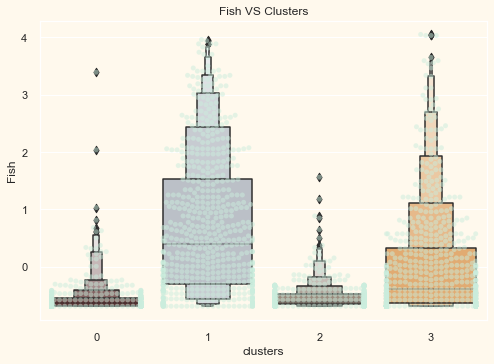

In [53]:
plt.figure()
pl=sns.swarmplot(x=output["clusters"], y=output["Fish"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["clusters"], y=output["Fish"], palette=pal)
pl.set_title("Fish VS Clusters")
plt.show()

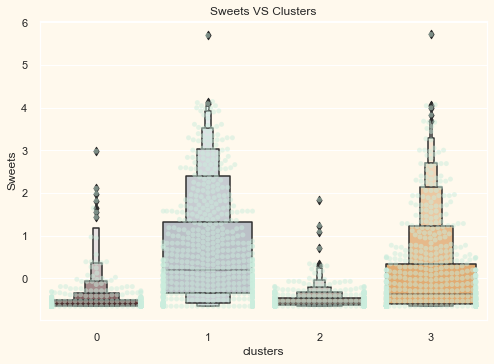

In [54]:
plt.figure()
pl=sns.swarmplot(x=output["clusters"], y=output["Sweets"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["clusters"], y=output["Sweets"], palette=pal)
pl.set_title("Sweets VS Clusters")
plt.show()

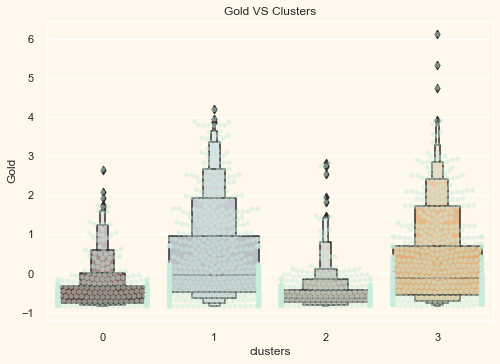

In [55]:
plt.figure()
pl=sns.swarmplot(x=output["clusters"], y=output["Gold"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["clusters"], y=output["Gold"], palette=pal)
pl.set_title("Gold VS Clusters")
plt.show()

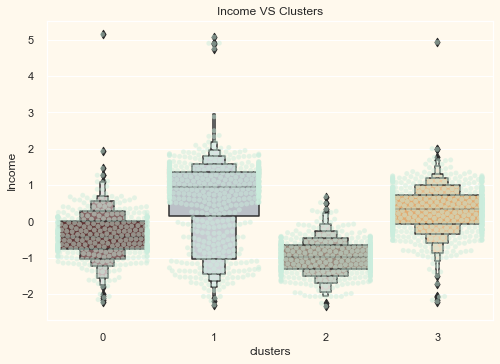

In [56]:
plt.figure()
pl=sns.swarmplot(x=output["clusters"], y=output["Income"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["clusters"], y=output["Income"], palette=pal)
pl.set_title("Income VS Clusters")
plt.show()

可以看出,在消費結構及收入結構上:  
● group0,group2較接近  
● group1,group3較接近  
但這是否會影響不同group之間是否接受推播?

In [49]:
output.columns

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'Wines', 'Fruits', 'Meat',
       'Fish', 'Sweets', 'Gold', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'Customer_For', 'Age', 'Spent', 'Children', 'Family_Size',
       'Living_With', 'Is_Parent', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
       'Education_Graduate', 'Education_Postgraduate', 'clusters'],
      dtype='object')

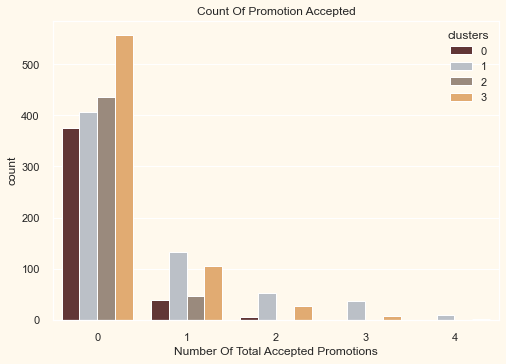

In [57]:
#Creating a feature to get a sum of accepted promotions 
output["Total_Promos"] = output["AcceptedCmp1"]+ output["AcceptedCmp2"]+ output["AcceptedCmp3"]+ output["AcceptedCmp4"]+ output["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=output["Total_Promos"],hue=output["clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

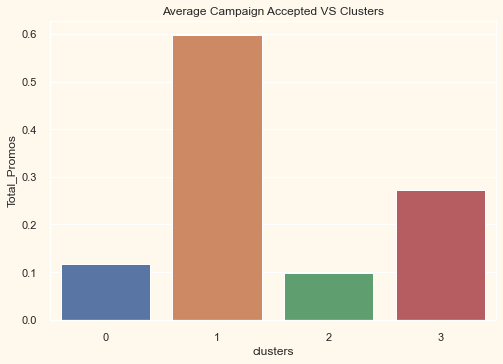

In [61]:
plt.figure()
pl=sns.barplot(x=output.groupby('clusters')['Total_Promos'].mean().index, y=output.groupby('clusters')['Total_Promos'].mean() )
pl.set_title("Average Campaign Accepted VS Clusters")
plt.show()

可以看出,在接受推播而言,group1明顯較其他人踴躍,緊接著為group3  
group0,group2則是差不多  
接著可根據基本資料分析不同組別之間的差異性

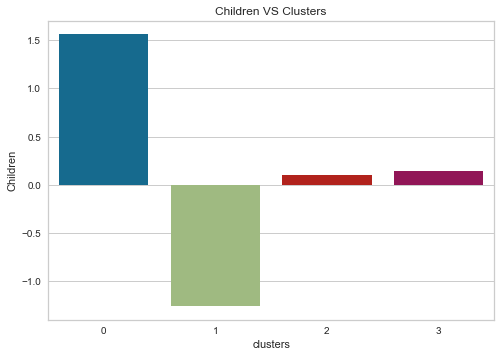

In [5]:
plt.figure()
pl=sns.barplot(x=output.groupby('clusters')['Children'].mean().index, y=output.groupby('clusters')['Children'].mean() )
pl.set_title("Children VS Clusters")
plt.show()

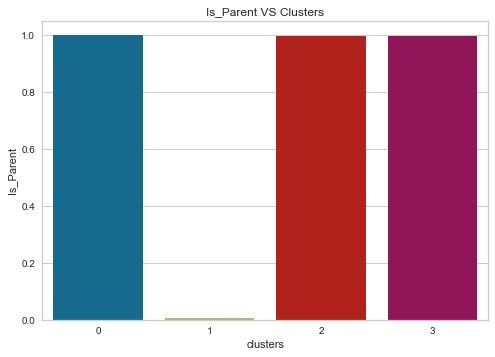

In [7]:
plt.figure()
pl=sns.barplot(x=output.groupby('clusters')['Is_Parent'].mean().index, y=output.groupby('clusters')['Is_Parent'].mean() )
pl.set_title("Is_Parent VS Clusters")
plt.show()

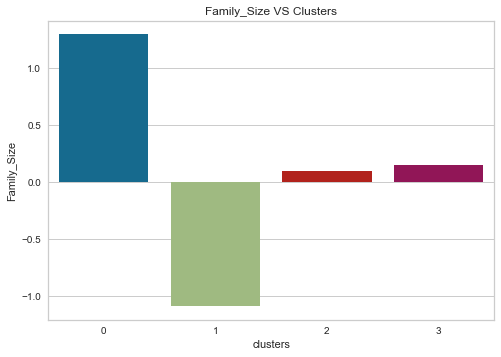

In [9]:
plt.figure()
pl=sns.barplot(x=output.groupby('clusters')['Family_Size'].mean().index, y=output.groupby('clusters')['Family_Size'].mean() )
pl.set_title("Family_Size VS Clusters")
plt.show()

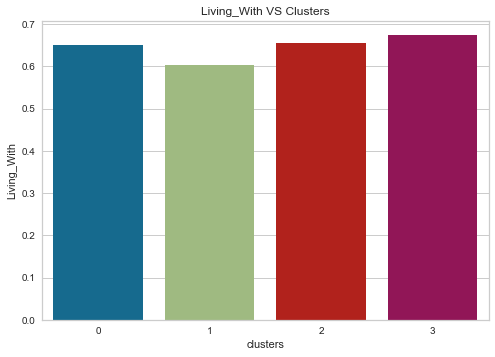

In [10]:
plt.figure()
pl=sns.barplot(x=output.groupby('clusters')['Living_With'].mean().index, y=output.groupby('clusters')['Living_With'].mean() )
pl.set_title("Living_With VS Clusters")
plt.show()

大致可以看出group1為非父母,有無伴侶則沒有特別差異  
group0及group2的差異則在group0內的兒童數量較多,family size普遍較大

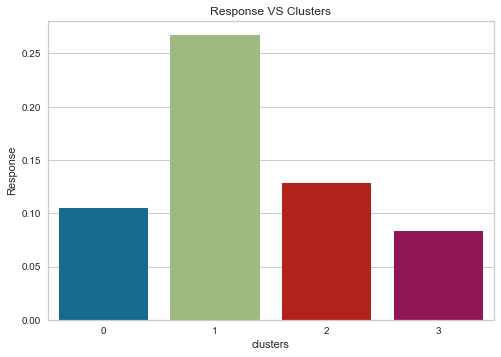

In [11]:
plt.figure()
pl=sns.barplot(x=output.groupby('clusters')['Response'].mean().index, y=output.groupby('clusters')['Response'].mean() )
pl.set_title("Response VS Clusters")
plt.show()

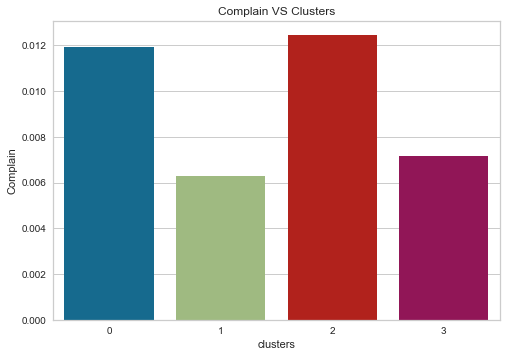

In [12]:
plt.figure()
pl=sns.barplot(x=output.groupby('clusters')['Complain'].mean().index, y=output.groupby('clusters')['Complain'].mean() )
pl.set_title("Complain VS Clusters")
plt.show()

從結果可以看出:  
group0:低消費低收入,子女數量多  
group1:高消費高收入,接受推播程度高,無子女  
group2:低消費低收入
group3:高消費高收入,接受推播程度普通  

最終從response也可看出group1明顯較踴躍  
而從complain可以看出group0及group4的complain情況較多  
若以客戶管理而言可以在group1多投入行銷資源  
在group0及group2上則投入較多相應措施減少complain

## 從Collaborative Filtering(協同過濾,CF)的角度進行分群

In [13]:
#從六大類商品建構user-item matrix
pivot_table = output[['Wines','Fruits','Meat','Fish','Sweets','Gold']]

In [14]:
#建構user-user CF
pivot_table_user = pivot_table.T

In [22]:
pivot_table_user.corrwith(pivot_table_user[5]).sort_values(ascending=False).head()

5       1.000000
2158    0.990070
1162    0.985209
1877    0.975802
1706    0.974298
dtype: float64

藉由得到user-user CF,可以建置graph  
以圖論角度進行分群

In [17]:
#使用networkX套件進行網路分析及作圖
import networkx as nx

In [43]:
start = np.array([])
end = np.array([])
weight = np.array([])
corr_table = pivot_table_user.corr()
for i in corr_table.columns:
    start = np.append(start,
    np.array([i]*len(corr_table[i].index))[i+1:]
    )
    end = np.append(end,
    np.array(corr_table[i].index)[i+1:]
    )
    weight = np.append(weight,
    np.array(corr_table[i].values)[i+1:]
    )


In [44]:
graph_df = pd.DataFrame({'start':start,'end':end,'weight':weight})

In [46]:
graph_df_filtered = graph_df[graph_df['weight']>0.5]

In [47]:
graph_df_filtered

start     end    weight
0           0.0     1.0  0.592209
1           0.0     2.0  0.673774
2           0.0     3.0  0.824463
3           0.0     4.0  0.672134
7           0.0     8.0  0.719522
...         ...     ...       ...
2498701  2227.0  2235.0  0.624993
2498705  2228.0  2232.0  0.995780
2498706  2228.0  2233.0  0.916972
2498709  2229.0  2230.0  0.885801
2498724  2232.0  2233.0  0.912618

[633730 rows x 3 columns]

In [ ]:
!pip install community
!pip install python-louvain

In [51]:
G = nx.from_pandas_edgelist(graph_df_filtered, 'start', 'end',edge_attr='weight')

In [60]:
from community import community_louvain
%matplotlib inline
#Louvain 演算法分群
#https://smiliu.xyz/posts/39382
partition = community_louvain.best_partition(G, resolution = 1)

community:  4.0


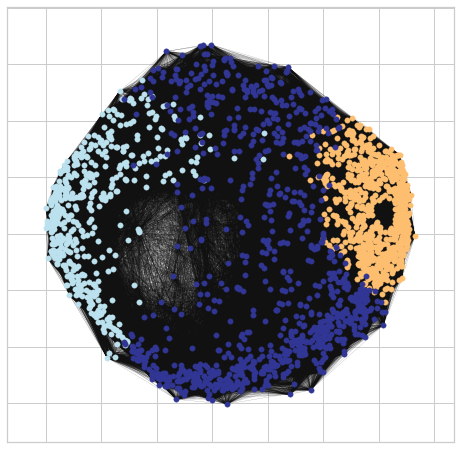

In [106]:
# #Louvain 演算法分群 Drawing(原code)
# size = float(len(set(partition.values())))  # community 群組
# pos = nx.spring_layout(G)  # nodes 的 xy軸
# cm = plt.cm.get_cmap('RdYlBu', size)
# count = 0.
# print('community: ', size)
# plt.figure(1, figsize=(8,8))
# for com in set(partition.values()) :
#     count += 1.
#     color_code = '#%02x%02x%02x' % (cm(count/size, bytes=True)[:3])  # RGB to color code
#     list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
#     nx.draw_networkx_nodes(G, pos, list_nodes, node_size=30, node_color=color_code)
#     nx.draw_networkx_labels(G, pos, font_size=10)

# nx.draw_networkx_edges(G, pos, width=0.1, alpha=1)
# plt.show()


community:  4.0


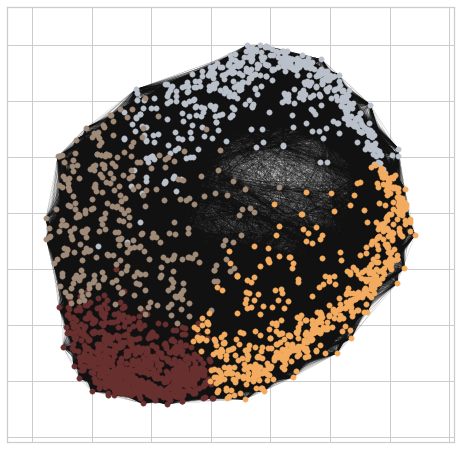

In [105]:
#Louvain 演算法分群 Drawing
size = float(len(set(partition.values())))  # community 群組
pos = nx.spring_layout(G)  # nodes 的 xy軸
cm = plt.cm.get_cmap('RdYlBu', size)
count = 0.
color_code = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]

print('community: ', size)
plt.figure(1, figsize=(8,8))
for com in set(partition.values()) :
    count += 1.
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size=30, node_color=color_code[com])
    #nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, width=0.1, alpha=1)
plt.show()

In [69]:
output['graph_clusters'] = output.index.map(lambda x:partition.get(x, None))

In [72]:
#檢查分群情況
output.groupby('graph_clusters')['clusters'].count()

graph_clusters
0    837
1    490
2    316
3    593
Name: clusters, dtype: int64

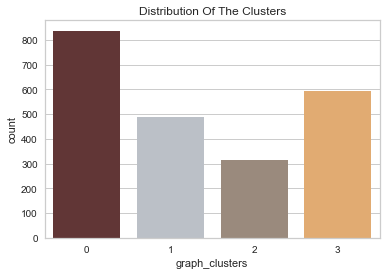

In [85]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=output["graph_clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

In [82]:
#兩種分群方法比較
pd.pivot_table(output,values='Response',index=['clusters'],columns=['graph_clusters'],aggfunc='count')

graph_clusters    0    1    2    3
clusters                          
0               217   59   14  129
1               170  136  196  134
2               312   13   17  140
3               138  282   89  190

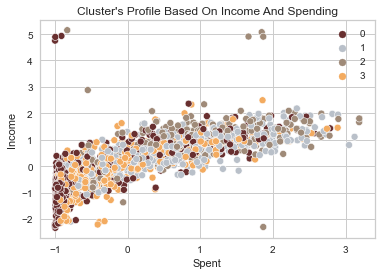

In [84]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.scatterplot(data = output,x=output["Spent"], y=output["Income"],hue=output["graph_clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

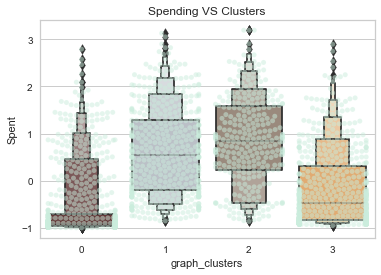

In [86]:
plt.figure()
pl=sns.swarmplot(x=output["graph_clusters"], y=output["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["graph_clusters"], y=output["Spent"], palette=pal)
pl.set_title("Spending VS Clusters")
plt.show()

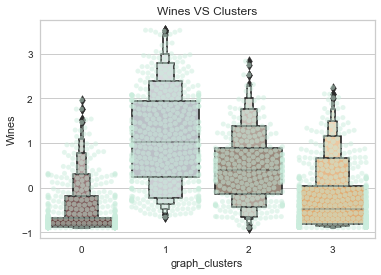

In [87]:
plt.figure()
pl=sns.swarmplot(x=output["graph_clusters"], y=output["Wines"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["graph_clusters"], y=output["Wines"], palette=pal)
pl.set_title("Wines VS Clusters")
plt.show()

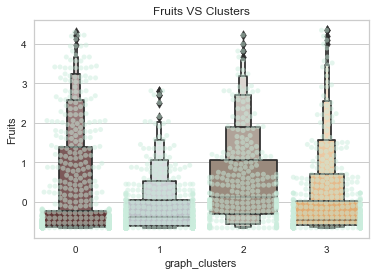

In [90]:
plt.figure()
pl=sns.swarmplot(x=output["graph_clusters"], y=output["Fruits"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["graph_clusters"], y=output["Fruits"], palette=pal)
pl.set_title("Fruits VS Clusters")
plt.show()

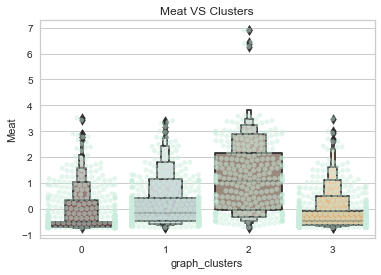

In [91]:
plt.figure()
pl=sns.swarmplot(x=output["graph_clusters"], y=output["Meat"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["graph_clusters"], y=output["Meat"], palette=pal)
pl.set_title("Meat VS Clusters")
plt.show()

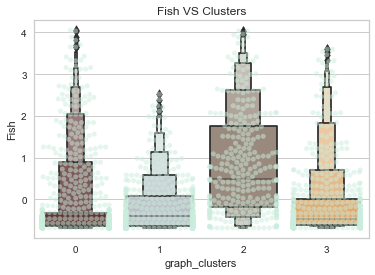

In [92]:
plt.figure()
pl=sns.swarmplot(x=output["graph_clusters"], y=output["Fish"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["graph_clusters"], y=output["Fish"], palette=pal)
pl.set_title("Fish VS Clusters")
plt.show()

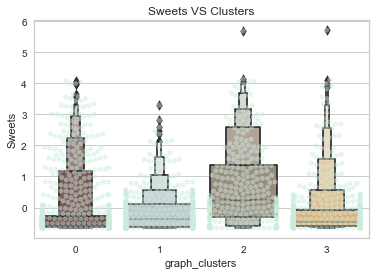

In [93]:
plt.figure()
pl=sns.swarmplot(x=output["graph_clusters"], y=output["Sweets"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["graph_clusters"], y=output["Sweets"], palette=pal)
pl.set_title("Sweets VS Clusters")
plt.show()

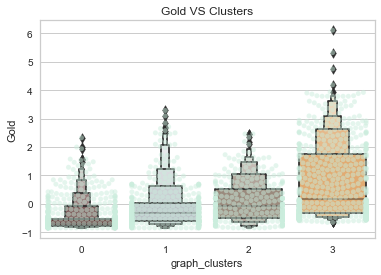

In [94]:
plt.figure()
pl=sns.swarmplot(x=output["graph_clusters"], y=output["Gold"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=output["graph_clusters"], y=output["Gold"], palette=pal)
pl.set_title("Gold VS Clusters")
plt.show()

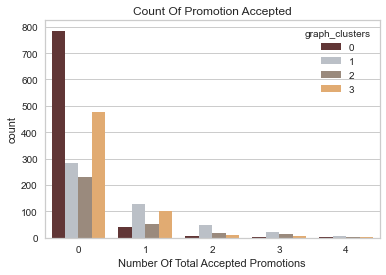

In [96]:
#Plotting count of total campaign accepted.
output["Total_Promos"] = output["AcceptedCmp1"]+ output["AcceptedCmp2"]+ output["AcceptedCmp3"]+ output["AcceptedCmp4"]+ output["AcceptedCmp5"]
plt.figure()
pl = sns.countplot(x=output["Total_Promos"],hue=output["graph_clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

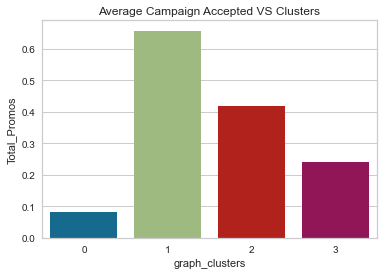

In [97]:
plt.figure()
pl=sns.barplot(x=output.groupby('graph_clusters')['Total_Promos'].mean().index, y=output.groupby('graph_clusters')['Total_Promos'].mean() )
pl.set_title("Average Campaign Accepted VS Clusters")
plt.show()

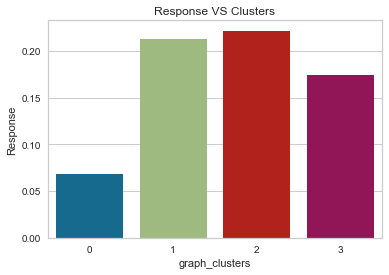

In [88]:
plt.figure()
pl=sns.barplot(x=output.groupby('graph_clusters')['Response'].mean().index, y=output.groupby('graph_clusters')['Response'].mean() )
pl.set_title("Response VS Clusters")
plt.show()

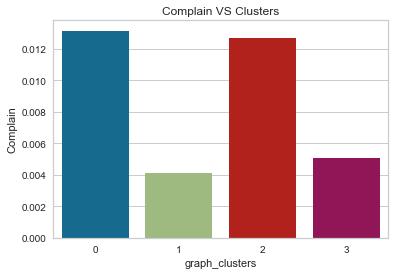

In [89]:
plt.figure()
pl=sns.barplot(x=output.groupby('graph_clusters')['Complain'].mean().index, y=output.groupby('graph_clusters')['Complain'].mean() )
pl.set_title("Complain VS Clusters")
plt.show()

基於消費習慣(各類型產品花費金額)所建立的user-user關聯性,並進一步以此繪製graph  
可以看出雖然消費習慣上response無法得出校明顯的結果  
但在各類型商品的消費習慣上不同組別確實有異(group3消費gold,group1&group2消費wine...)  
在商品推薦上可以較精準,辦活動時則可以根據活動的商品類型,決定是否進行推薦及花費宣傳資源在特定人身上  
由於不知道各campaign內容,是否為滿額折扣or特定商品折扣,因此難以根據目前擁有的資料分析效果